## Modeling: Small business loans

We will now build a model to classify small business loans, according to whether they will be paid off or default. We will try two algorithms: random forest, and gradient boosting. To improve performance, we will tune hyperparameters for both algorithms.

### Loading the data

In [3]:
## Import needed Python module and functions 
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [4]:
## Import features for training values
features = pd.read_csv('../Data/Processed/X_train.csv')

In [5]:
## Import labels for training data
labels = pd.read_csv('../Data/Processed/y_train.csv')

In [6]:
## Split training set into training and validation sets,
## to validate 'out of the box' models.
feature_names = features.columns
X = features.values
y = labels.values
y = y.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, random_state=42)

In [ ]:
### Random forest model

In [7]:
rf_model = RandomForestClassifier()

In [8]:
%%time
rf_model.fit(X_train, y_train)

CPU times: user 2min 11s, sys: 340 ms, total: 2min 11s
Wall time: 2min 11s


RandomForestClassifier()

In [32]:
%%time
rf_pred = rf_model.predict(X_test)
print(accuracy_score(y_test, rf_pred), f1_score(y_test, rf_pred))

0.9293674673480022 0.779410992703029
CPU times: user 5.04 s, sys: 232 ms, total: 5.27 s
Wall time: 5.41 s


In [11]:
%%time
cross_val_score(rf_model, X, y, scoring='f1', cv=3, n_jobs=1)

CPU times: user 5min 8s, sys: 1.18 s, total: 5min 9s
Wall time: 5min 9s


array([0.77802666, 0.77822783, 0.78170823])

In [12]:
params = {'n_estimators': [10, 50, 100, 200],
          'criterion' : ['gini', 'entropy'],
          'max_depth': [10, 50, 100, None]
}

rf_for_search = RandomForestClassifier()

In [13]:
from sklearn.model_selection import GridSearchCV
search_results_rf = GridSearchCV(estimator=rf_for_search, param_grid=params, cv=3, scoring=('accuracy', 'f1'), refit='f1', n_jobs=1, verbose=5)

In [14]:
search_results_rf.fit(X, y)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV 1/3] END criterion=gini, max_depth=10, n_estimators=10; accuracy: (test=0.895) f1: (test=0.630) total time=   6.2s
[CV 2/3] END criterion=gini, max_depth=10, n_estimators=10; accuracy: (test=0.882) f1: (test=0.539) total time=   5.7s
[CV 3/3] END criterion=gini, max_depth=10, n_estimators=10; accuracy: (test=0.888) f1: (test=0.586) total time=   5.8s
[CV 1/3] END criterion=gini, max_depth=10, n_estimators=50; accuracy: (test=0.887) f1: (test=0.572) total time=  26.7s
[CV 2/3] END criterion=gini, max_depth=10, n_estimators=50; accuracy: (test=0.883) f1: (test=0.546) total time=  27.0s
[CV 3/3] END criterion=gini, max_depth=10, n_estimators=50; accuracy: (test=0.891) f1: (test=0.603) total time=  27.5s
[CV 1/3] END criterion=gini, max_depth=10, n_estimators=100; accuracy: (test=0.878) f1: (test=0.506) total time= 1.0min
[CV 2/3] END criterion=gini, max_depth=10, n_estimators=100; accuracy: (test=0.888) f1: (test=0.579) tota

[CV 3/3] END criterion=entropy, max_depth=50, n_estimators=100; accuracy: (test=0.929) f1: (test=0.779) total time= 1.7min
[CV 1/3] END criterion=entropy, max_depth=50, n_estimators=200; accuracy: (test=0.930) f1: (test=0.783) total time= 3.4min
[CV 2/3] END criterion=entropy, max_depth=50, n_estimators=200; accuracy: (test=0.929) f1: (test=0.782) total time= 3.5min
[CV 3/3] END criterion=entropy, max_depth=50, n_estimators=200; accuracy: (test=0.930) f1: (test=0.782) total time= 3.6min
[CV 1/3] END criterion=entropy, max_depth=100, n_estimators=10; accuracy: (test=0.918) f1: (test=0.737) total time=  14.0s
[CV 2/3] END criterion=entropy, max_depth=100, n_estimators=10; accuracy: (test=0.923) f1: (test=0.755) total time=  12.3s
[CV 3/3] END criterion=entropy, max_depth=100, n_estimators=10; accuracy: (test=0.918) f1: (test=0.735) total time=  12.4s
[CV 1/3] END criterion=entropy, max_depth=100, n_estimators=50; accuracy: (test=0.928) f1: (test=0.775) total time=  54.3s
[CV 2/3] END cri

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 50, 100, None],
                         'n_estimators': [10, 50, 100, 200]},
             refit='f1', scoring=('accuracy', 'f1'), verbose=5)

In [19]:
param_results = pd.DataFrame(search_results_rf.cv_results_)
param_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_f1,split1_test_f1,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,5.517395,0.202401,0.367942,0.006439,gini,10,10,"{'criterion': 'gini', 'max_depth': 10, 'n_esti...",0.895281,0.882286,0.888352,0.888640,0.005309,25,0.629892,0.538776,0.585688,0.584786,0.037204,25
1,25.809513,0.307162,1.266790,0.004469,gini,10,50,"{'criterion': 'gini', 'max_depth': 10, 'n_esti...",0.887485,0.883168,0.890813,0.887155,0.003130,27,0.572059,0.545779,0.603312,0.573717,0.023517,27
2,53.109004,3.505890,2.388468,0.024497,gini,10,100,"{'criterion': 'gini', 'max_depth': 10, 'n_esti...",0.878105,0.887747,0.886295,0.884049,0.004245,31,0.506492,0.579429,0.564475,0.550132,0.031456,31
3,101.098638,0.150238,4.603487,0.015438,gini,10,200,"{'criterion': 'gini', 'max_depth': 10, 'n_esti...",0.886380,0.887112,0.886229,0.886574,0.000385,28,0.573446,0.574103,0.564670,0.570740,0.004301,28
4,9.227806,0.031870,0.900147,0.010473,gini,50,10,"{'criterion': 'gini', 'max_depth': 50, 'n_esti...",0.921055,0.916728,0.921650,0.919811,0.002193,21,0.747561,0.730105,0.750269,0.742645,0.008936,21


In [21]:
my_scores = param_results[['param_criterion', 'param_n_estimators', 'param_max_depth', 'mean_test_accuracy', 'mean_test_f1', 'mean_fit_time']]

In [26]:
my_scores.sort_values(by='mean_test_f1', ascending=False).head(10)

,param_criterion,param_n_estimators,param_max_depth,mean_test_accuracy,mean_test_f1,mean_fit_time
27,entropy,200,100,0.929900,0.782984,190.626250
23,entropy,200,50,0.929594,0.782423,194.183892
7,gini,200,50,0.929784,0.782170,183.345557
26,entropy,100,100,0.929597,0.781712,95.353976
11,gini,200,100,0.929631,0.781373,182.045867
30,entropy,100,None,0.929227,0.780617,95.937817
31,entropy,200,None,0.929169,0.780384,193.829998
6,gini,100,50,0.929241,0.780141,91.352666
15,gini,200,None,0.929254,0.780122,212.592106
22,entropy,100,50,0.928999,0.780100,95.449380


In [27]:
search_results_rf.best_params_

{'criterion': 'entropy', 'max_depth': 100, 'n_estimators': 200}

In [61]:
bigger_rf = RandomForestClassifier()
big_params = {'n_estimators': [400],
          'criterion' : ['entropy'],
          'max_depth': [50, 100, 200]
}

In [62]:
search_results_rf_bigger = GridSearchCV(estimator=bigger_rf, param_grid=big_params, cv=3, scoring=('accuracy', 'f1'), refit='f1', n_jobs=1, verbose=5)

In [63]:
search_results_rf_bigger.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END criterion=entropy, max_depth=50, n_estimators=400; accuracy: (test=0.930) f1: (test=0.783) total time= 6.4min
[CV 2/3] END criterion=entropy, max_depth=50, n_estimators=400; accuracy: (test=0.929) f1: (test=0.780) total time= 5.5min
[CV 3/3] END criterion=entropy, max_depth=50, n_estimators=400; accuracy: (test=0.929) f1: (test=0.779) total time= 5.5min
[CV 1/3] END criterion=entropy, max_depth=100, n_estimators=400; accuracy: (test=0.929) f1: (test=0.780) total time= 5.7min
[CV 2/3] END criterion=entropy, max_depth=100, n_estimators=400; accuracy: (test=0.929) f1: (test=0.780) total time= 5.4min
[CV 3/3] END criterion=entropy, max_depth=100, n_estimators=400; accuracy: (test=0.929) f1: (test=0.780) total time= 5.4min
[CV 1/3] END criterion=entropy, max_depth=200, n_estimators=400; accuracy: (test=0.929) f1: (test=0.780) total time= 5.4min
[CV 2/3] END criterion=entropy, max_depth=200, n_estimators=400; accuracy: (

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=1,
             param_grid={'criterion': ['entropy'], 'max_depth': [50, 100, 200],
                         'n_estimators': [400]},
             refit='f1', scoring=('accuracy', 'f1'), verbose=5)

In [29]:
gb_model = GradientBoostingClassifier()

In [30]:
%%time 
gb_model.fit(X, y)

CPU times: user 3min 33s, sys: 372 ms, total: 3min 34s
Wall time: 3min 34s


GradientBoostingClassifier()

In [31]:
%%time
gb_pred = gb_model.predict(X_test)
print(accuracy_score(y_test, gb_pred), f1_score(y_test, gb_pred))

0.9287455245331226 0.7818434460398332
CPU times: user 504 ms, sys: 136 ms, total: 640 ms
Wall time: 836 ms


In [36]:
%%time
cross_val_score(gb_model, X, y, scoring='f1', cv=3, n_jobs=1)

CPU times: user 14min 11s, sys: 2 s, total: 14min 13s
Wall time: 14min 16s


array([0.78288344, 0.78454667, 0.78655406])

In [43]:
params_gb = {'n_estimators': [100, 200],
          'max_depth': [3, 7, 11, 15],
          'learning_rate': [0.01, 0.1, 1],
          'loss': ['deviance', 'exponential']}

gb_for_search = GradientBoostingClassifier()

In [44]:
search_results_gb = GridSearchCV(estimator=gb_for_search, param_grid=params_gb, cv=3, scoring=('accuracy', 'f1'), refit='f1', n_jobs=1, verbose=5)

In [45]:
%%time
search_results_gb.fit(X, y)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 1/3] END learning_rate=0.01, loss=deviance, max_depth=3, n_estimators=100; accuracy: (test=0.880) f1: (test=0.546) total time= 5.2min
[CV 2/3] END learning_rate=0.01, loss=deviance, max_depth=3, n_estimators=100; accuracy: (test=0.880) f1: (test=0.547) total time= 6.5min
[CV 3/3] END learning_rate=0.01, loss=deviance, max_depth=3, n_estimators=100; accuracy: (test=0.881) f1: (test=0.550) total time= 4.3min
[CV 1/3] END learning_rate=0.01, loss=deviance, max_depth=3, n_estimators=200; accuracy: (test=0.906) f1: (test=0.701) total time= 9.4min
[CV 2/3] END learning_rate=0.01, loss=deviance, max_depth=3, n_estimators=200; accuracy: (test=0.907) f1: (test=0.707) total time=12.6min
[CV 3/3] END learning_rate=0.01, loss=deviance, max_depth=3, n_estimators=200; accuracy: (test=0.906) f1: (test=0.704) total time=11.9min
[CV 1/3] END learning_rate=0.01, loss=deviance, max_depth=7, n_estimators=100; accuracy: (test=0.927) f1: (tes

[CV 3/3] END learning_rate=0.1, loss=deviance, max_depth=7, n_estimators=200; accuracy: (test=0.946) f1: (test=0.843) total time=17.0min
[CV 1/3] END learning_rate=0.1, loss=deviance, max_depth=11, n_estimators=100; accuracy: (test=0.946) f1: (test=0.844) total time=12.7min
[CV 2/3] END learning_rate=0.1, loss=deviance, max_depth=11, n_estimators=100; accuracy: (test=0.946) f1: (test=0.843) total time=12.7min
[CV 3/3] END learning_rate=0.1, loss=deviance, max_depth=11, n_estimators=100; accuracy: (test=0.947) f1: (test=0.846) total time=12.7min
[CV 1/3] END learning_rate=0.1, loss=deviance, max_depth=11, n_estimators=200; accuracy: (test=0.947) f1: (test=0.844) total time=25.8min
[CV 2/3] END learning_rate=0.1, loss=deviance, max_depth=11, n_estimators=200; accuracy: (test=0.946) f1: (test=0.843) total time=25.8min
[CV 3/3] END learning_rate=0.1, loss=deviance, max_depth=11, n_estimators=200; accuracy: (test=0.947) f1: (test=0.846) total time=26.0min
[CV 1/3] END learning_rate=0.1, los

[CV 3/3] END learning_rate=1, loss=deviance, max_depth=15, n_estimators=200; accuracy: (test=0.889) f1: (test=0.704) total time=35.9min
[CV 1/3] END learning_rate=1, loss=exponential, max_depth=3, n_estimators=100; accuracy: (test=0.943) f1: (test=0.832) total time= 3.8min
[CV 2/3] END learning_rate=1, loss=exponential, max_depth=3, n_estimators=100; accuracy: (test=0.941) f1: (test=0.828) total time= 3.9min
[CV 3/3] END learning_rate=1, loss=exponential, max_depth=3, n_estimators=100; accuracy: (test=0.943) f1: (test=0.832) total time= 3.9min
[CV 1/3] END learning_rate=1, loss=exponential, max_depth=3, n_estimators=200; accuracy: (test=0.944) f1: (test=0.837) total time= 7.7min
[CV 2/3] END learning_rate=1, loss=exponential, max_depth=3, n_estimators=200; accuracy: (test=0.943) f1: (test=0.834) total time= 7.7min
[CV 3/3] END learning_rate=1, loss=exponential, max_depth=3, n_estimators=200; accuracy: (test=0.945) f1: (test=0.839) total time= 7.7min
[CV 1/3] END learning_rate=1, loss=e

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=1,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'loss': ['deviance', 'exponential'],
                         'max_depth': [3, 7, 11, 15],
                         'n_estimators': [100, 200]},
             refit='f1', scoring=('accuracy', 'f1'), verbose=5)

In [90]:
gb_param_results = pd.DataFrame(search_results_gb.cv_results_)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_learning_rate', 'param_loss', 'param_max_depth',
       'param_n_estimators', 'params', 'split0_test_accuracy',
       'split1_test_accuracy', 'split2_test_accuracy', 'mean_test_accuracy',
       'std_test_accuracy', 'rank_test_accuracy', 'split0_test_f1',
       'split1_test_f1', 'split2_test_f1', 'mean_test_f1', 'std_test_f1',
       'rank_test_f1'],
      dtype='object')

In [49]:
my_param_scores_gb = gb_param_results[['param_learning_rate', 'param_loss', 'param_max_depth', 'param_n_estimators', 'mean_test_accuracy', 'mean_test_f1', 'mean_fit_time']]

In [51]:
my_param_scores_gb.sort_values(by='mean_test_f1', ascending=False).head(10)

,param_learning_rate,param_loss,param_max_depth,param_n_estimators,mean_test_accuracy,mean_test_f1,mean_fit_time
29,0.1,exponential,11,200,0.947543,0.847000,1551.407778
28,0.1,exponential,11,100,0.947141,0.845609,760.776232
20,0.1,deviance,11,100,0.946553,0.844482,761.056376
21,0.1,deviance,11,200,0.946434,0.844471,1550.076511
31,0.1,exponential,15,200,0.946087,0.842705,2173.029280
30,0.1,exponential,15,100,0.945892,0.842232,1087.515162
19,0.1,deviance,7,200,0.945770,0.840664,1018.495597
27,0.1,exponential,7,200,0.945412,0.839358,1027.062723
23,0.1,deviance,15,200,0.944623,0.839153,2172.095088
22,0.1,deviance,15,100,0.944542,0.839121,1079.212461


In [53]:
search_results_gb.best_params_

{'learning_rate': 0.1,
 'loss': 'exponential',
 'max_depth': 11,
 'n_estimators': 200}

In [65]:
search_results_gb.best_estimator_

GradientBoostingClassifier(loss='exponential', max_depth=11, n_estimators=200)

In [67]:
X_val_df = pd.read_csv('../Data/Processed/X_test.csv')
y_val_df = pd.read_csv('../Data/Processed/y_test.csv')

In [68]:
X_val = X_val_df.values
y_val = y_val_df.values
y_val = y_val.ravel()

In [69]:
best_gb_model = search_results_gb.best_estimator_

In [74]:
best_gb_model.fit(X, y)

GradientBoostingClassifier(loss='exponential', max_depth=11, n_estimators=200)

In [76]:
y_val_pred = best_gb_model.predict(X_val)

In [77]:
f1_score(y_val, y_val_pred)

0.8502062220800439

In [78]:
accuracy_score(y_val, y_val_pred)

0.9485764489470939

In [81]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val_pred, y_val)

array([[204642,   7345],
       [  5766,  37208]])

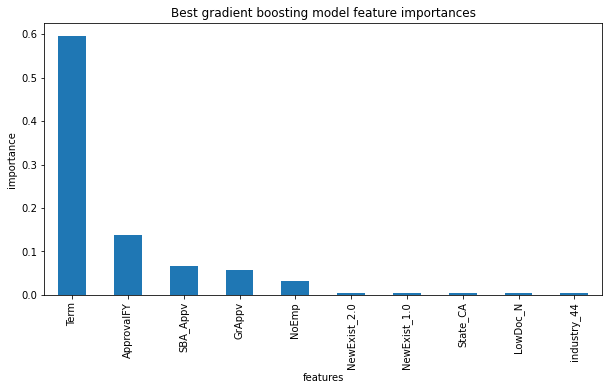

In [88]:
import matplotlib.pyplot as plt

plt.subplots(figsize=(10, 5))
importances = best_gb_model.feature_importances_
labeled_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:10]
labeled_importances.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best gradient boosting model feature importances');